# DT logs prediction model

## Contents

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation](#Metrics-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Predict DT logs values based on other logs values and depth info.

In [1]:
%env CUDA_VISIBLE_DEVICES=2

import os
import sys

import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "/notebooks/goryachev/petroflow")

from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V, L
from petroflow.batchflow.models.torch import UNet
from petroflow.models.logs_prediction.utils import build_dataset, calc_metrics, moving_average_1d, save_results

env: CUDA_VISIBLE_DEVICES=2


## Dataset

A datased of 608 wells with filtered data.

In [2]:
FILTERED_DATASET_PATH = "../data/filtered/*"
filtered_dataset = WellDataset(path=FILTERED_DATASET_PATH, dirs=True)

DT values are predicted by GK, NKTD and GZ1 logs and depth info.

In [10]:
INPUTS_COL = ['GK', 'NKTD', 'GZ1', "DEPTH KM"]
TARGET_COL = ['DT']
PROPER_COL = INPUTS_COL + TARGET_COL

4 crops of length 6.4m will be sampled from each well in a batch.

In [4]:
N_CROPS = 8
CROP_SIZE = 64
REINDEXATION_STEP = 0.1
CROP_LENGTH = CROP_SIZE * REINDEXATION_STEP

Split logs by non nan segments.

In [5]:
split_pipeline = filtered_dataset >> Pipeline().drop_nans()
batch = split_pipeline.next_batch(filtered_dataset.size)
dataset = build_dataset(batch)
dataset.split(shuffle=11)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Model architecture

UNet model is used for logs prediction (https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.unet.html).

Model configuration:
* input shape - [4, 64] (3 types of logs and depth info)
* output shape - [1, 64] - (DT logs)
* the number of filters in encoder and corresponding decoder blocks - [64, 128, 256, 512, 1024]
* each encoder and decoder block has "cna cna" layout with a kernel size of 3 and a ReLU activation
* downsampling in the encoder is performed by a max pooling operation with a kernel size and a stride of 2
* upsampling in the decoder is performed by a transposed convolution with a kernel size of 4 and a stride of 2, followed by batch normalization and a ReLU activation.

Adam optimizer with default parameters is used for model training. Mean-squared error is used as a loss function.

Model configuration specification:

In [6]:
INPUTS_SIZE = len(INPUTS_COL)
TARGET_SIZE = len(TARGET_COL)

model_config = {
    'initial_block/inputs': 'inputs',
    'inputs/inputs': {'shape': [INPUTS_SIZE, CROP_SIZE]},
    'inputs/target': {'shape': [TARGET_SIZE, CROP_SIZE]},
    'head/num_classes': 1,
    'loss': 'mse',
    'device' : torch.device("cuda:0")
}

## Model training

In [12]:
train_template = (Pipeline()
    .add_namespace(np)
    .random_crop(CROP_LENGTH, N_CROPS)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .swapaxes(B("target"), 1, 2, save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('loss_history', default=[])
    .init_model('dynamic', UNet, 'unet', model_config)
    .train_model('unet', B('inputs'), B('target'), fetches='loss', save_to=V('loss_history', mode='a'))
)

train_pipeline = dataset.train >> train_template

The model is trained for 1000 epochs with a batch size of 32.

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 1000
train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, drop_last=True, bar='n')

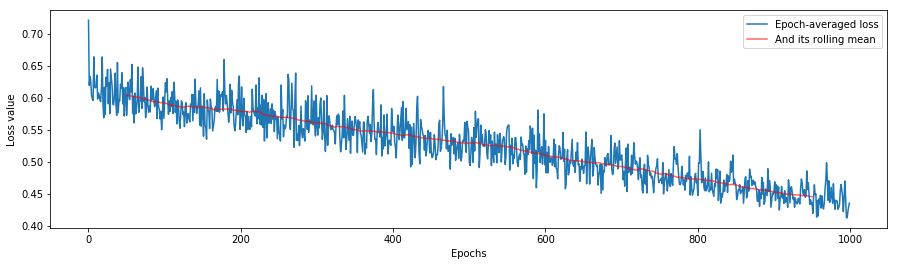

In [15]:
loss_history = train_pipeline.get_variable("loss_history")
epoch_averaged = np.array([np.mean(l) for l in np.array_split(loss_history, N_EPOCHS)])
rolling_averaged = moving_average_1d(epoch_averaged, 100)

fig = plt.figure(figsize=(15, 4))
plt.plot(epoch_averaged)
plt.plot(rolling_averaged, 'r', alpha=0.6)
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend(["Epoch-averaged loss", "And its rolling mean"])
plt.show()

Training loss doesn't reach a plateau by the end of the training, meaning that the learning process requires more epochs to converge.

## Inference

Inference pipeline is similar to the training one, except for one major difference:
* `random_crop` method is changed to `crop`

In [16]:
test_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .swapaxes(B("target"), 1, 2, save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('targets', default=[])
    .update(V('targets', mode='a'), B('target'))
    .init_variable('predictions', default=[])
    .import_model('unet', train_pipeline)
    .predict_model('unet', B('inputs'), fetches='predictions', save_to=V('predictions', mode='a'))
)

## Metrics evaluation

Two metrics used for model evaluation:
* Mean squared error (MSE)
* Proportion of variance explained by model to data variance (R^2)

Predict DT values on single batch.

In [34]:
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=1, n_iters=1, shuffle=True, drop_last=False)

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 0.307
R^2: 0.693


Plot several randomly chosen predictions.

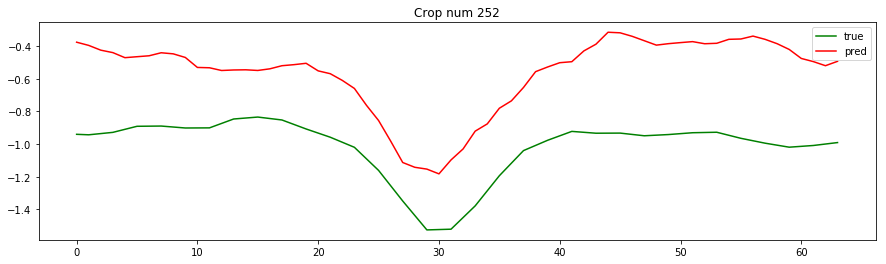

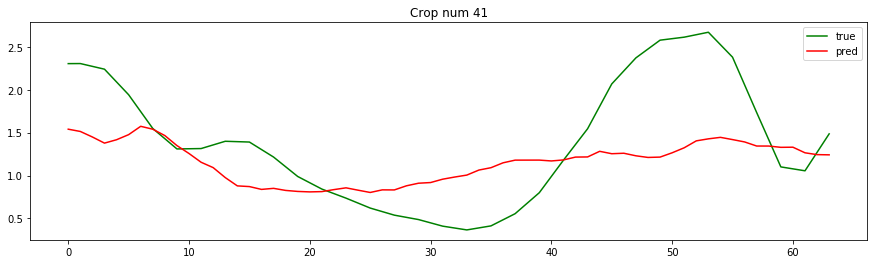

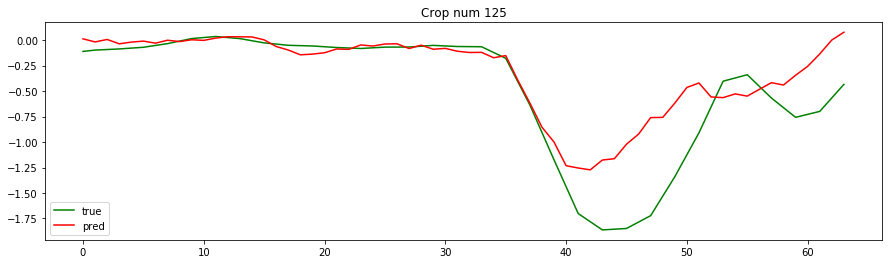

In [35]:
BATCH_NUM = np.random.randint(len(test_pipeline.v('predictions')))
GRAPH_NUM = test_pipeline.v('predictions')[BATCH_NUM].shape[0]
PRINT_NUM = 3
for crop_num in np.random.choice(GRAPH_NUM, PRINT_NUM, replace=False):
    true = test_pipeline.v('targets')[BATCH_NUM][crop_num, 0, :]
    pred = test_pipeline.v('predictions')[BATCH_NUM][crop_num, 0,:]

    fig = plt.figure(figsize=(15, 4))
    plt.title("Crop num {}".format(crop_num))
    plt.plot(true, 'g')
    plt.plot(pred, 'r')
    plt.legend(['true', 'pred'])
    plt.show()

Calculate metrics on whole test dataset

In [38]:
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=BATCH_SIZE, n_epochs=1, drop_last=False, bar='n')

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




MSE: 0.605
R^2: 0.381


In [49]:
with open("../linear/metrics", 'rb') as f:
    linear_metrics = pickle.load(f)
with open("../dense/metrics", 'rb') as f:
    dense_metrics = pickle.load(f)
    
linear = [np.round(v, 3) for v in linear_metrics.values()]
dense = [np.round(v, 3) for v in dense_metrics.values()]
unet = [np.round(v, 3) for v in metrics.values()]

df = pd.DataFrame(index=metrics.keys(), data=np.array([linear, dense, unet]).T, columns=['linear', 'dense', 'unet'])
df

,linear,dense,unet
MSE,0.646,0.634,0.605
R^2,0.338,0.351,0.381


## Conclusion

UNet model performance is slightly better than simple dense network.

After completing researches on optimal train stop moment and best architecture modifications it might perform better.

Save model.

In [48]:
save_results(train_pipeline.m('unet'), train_pipeline.v('loss_history'), metrics)